In [185]:
import os
import sys
sys.path.insert(0, '/home/byounggun/MapTR')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import geopandas as gpd
from shapely.geometry import box, LineString, Polygon, Point

# NuPlan map imports
from nuplan.database.maps_db.gpkg_mapsdb import GPKGMapsDB
from nuplan.common.maps.nuplan_map.nuplan_map import NuPlanMap

print('Imports successful!')

Imports successful!


## 1. 맵 데이터베이스 로드

In [186]:
# NavSim 맵 경로
map_root = '/home/byounggun/MapTR/data/navsim/download/maps'

# 사용 가능한 맵 위치 및 버전
map_info = {
    'us-nv-las-vegas-strip': '9.15.1915',
    'us-ma-boston': '9.17.1964',  # 버전 확인 필요
    'us-pa-pittsburgh-hazelwood': '9.17.1937',
    'sg-one-north': '9.17.1964'
}

# 버전 자동 탐색
import os
for loc in map_info.keys():
    loc_path = os.path.join(map_root, loc)
    if os.path.exists(loc_path):
        subdirs = [d for d in os.listdir(loc_path) if os.path.isdir(os.path.join(loc_path, d))]
        if subdirs:
            map_info[loc] = subdirs[0]
            
print('맵 위치 및 버전:')
for loc, ver in map_info.items():
    print(f'  {loc}: {ver}')

# 첫 번째 위치로 테스트
location = 'us-nv-las-vegas-strip'
version = map_info[location]
map_path = os.path.join(map_root, location, version, 'map.gpkg')
print(f'\nLoading map: {map_path}')
print(f'Exists: {os.path.exists(map_path)}')

맵 위치 및 버전:
  us-nv-las-vegas-strip: 9.15.1915
  us-ma-boston: 9.12.1817
  us-pa-pittsburgh-hazelwood: 9.17.1937
  sg-one-north: 9.17.1964

Loading map: /home/byounggun/MapTR/data/navsim/download/maps/us-nv-las-vegas-strip/9.15.1915/map.gpkg
Exists: True


In [187]:
# GPKGMapsDB는 사용하지 않고 직접 GPKG 파일을 읽음
# (GPKGMapsDB는 map_version 인자가 필요해서 복잡함)
print(f'Using map_path: {map_path}')
print(f'Exists: {os.path.exists(map_path)}')

Using map_path: /home/byounggun/MapTR/data/navsim/download/maps/us-nv-las-vegas-strip/9.15.1915/map.gpkg
Exists: True


## 2. 모든 레이어 확인

In [188]:
import sqlite3

# GPKG 파일에서 직접 테이블 목록 조회
conn = sqlite3.connect(map_path)
cursor = conn.cursor()

# gpkg_contents에서 레이어 목록 가져오기
cursor.execute("SELECT table_name, data_type, identifier FROM gpkg_contents")
layers = cursor.fetchall()

print(f'=== {location} 맵의 레이어 목록 ===')
print(f'총 {len(layers)}개 레이어\n')

for table_name, data_type, identifier in layers:
    print(f'- {table_name} ({data_type}): {identifier}')

conn.close()

=== us-nv-las-vegas-strip 맵의 레이어 목록 ===
총 32개 레이어

- Occupancy (tiles): Occupancy
- Intensity (tiles): Intensity
- Radar (tiles): Radar
- baseline_paths (features): baseline_paths
- carpark_areas (features): carpark_areas
- generic_drivable_areas (features): generic_drivable_areas
- dubins_nodes (features): dubins_nodes
- lane_connectors (features): lane_connectors
- intersections (features): intersections
- boundaries (features): boundaries
- crosswalks (features): crosswalks
- lanes_polygons (features): lanes_polygons
- lane_group_connectors (features): lane_group_connectors
- lane_groups_polygons (features): lane_groups_polygons
- road_segments (features): road_segments
- stop_polygons (features): stop_polygons
- traffic_lights (features): traffic_lights
- walkways (features): walkways
- meta (attributes): meta
- gen_lane_connectors_scaled_width_polygons (features): gen_lane_connectors_scaled_width_polygons
- semantic_prior (tiles): semantic_prior
- semantic_prior_distance_px (2d-gr

In [189]:
# 각 레이어의 상세 정보 확인
conn = sqlite3.connect(map_path)

layer_info = {}
for table_name, data_type, identifier in layers:
    # 레코드 수 확인
    cursor = conn.cursor()
    try:
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        count = cursor.fetchone()[0]
        
        # 컬럼 정보
        cursor.execute(f"PRAGMA table_info({table_name})")
        columns = cursor.fetchall()
        col_names = [col[1] for col in columns]
        
        layer_info[table_name] = {
            'count': count,
            'columns': col_names,
            'data_type': data_type
        }
    except Exception as e:
        print(f'Error with {table_name}: {e}')

conn.close()

# 정보 출력
print('=== 레이어별 상세 정보 ===')
for name, info in sorted(layer_info.items(), key=lambda x: -x[1]['count']):
    print(f"\n{name} ({info['data_type']})")
    print(f"  Records: {info['count']}")
    print(f"  Columns: {info['columns']}")

=== 레이어별 상세 정보 ===

semantic_prior (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

walkway (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

drivable_area (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

inactive_vehicle_estimation_zone (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

data_association_hard_filter (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

lidar_detection_hard_filter (tiles)
  Records: 32214
  Columns: ['id', 'zoom_level', 'tile_column', 'tile_row', 'tile_data']

boundaries (features)
  Records: 12092
  Columns: ['fid', 'geom', 'boundary_segment_fids', 'has_reflectors', 'boundary_type_fid', 'creator_id']

dubins_nodes (features)
  Records: 5444
  Columns: ['fid', 'geom', 'radius', 'heading', 'creator_id']

baseline_paths (f

## 3. 주요 레이어 탐색

In [190]:
# GeoDataFrame으로 각 레이어 로드
def load_layer(map_path, layer_name):
    try:
        gdf = gpd.read_file(map_path, layer=layer_name)
        return gdf
    except Exception as e:
        print(f'Error loading {layer_name}: {e}')
        return None

# 사용 가능한 레이어 확인
import sqlite3
conn = sqlite3.connect(map_path)
cursor = conn.cursor()
cursor.execute("SELECT table_name FROM gpkg_contents")
available_layers = [row[0] for row in cursor.fetchall()]
conn.close()
print(f'Available layers ({len(available_layers)}): {available_layers}')

# 주요 레이어 로드
loaded_layers = {}
key_layers = ['lane_connectors', 'boundaries', 'road_segments', 'lanes_polygons', 'crosswalks']

for layer_name in key_layers:
    if layer_name in available_layers:
        loaded_layers[layer_name] = load_layer(map_path, layer_name)

# 변수에 할당 (편의상)
lane_connectors = loaded_layers.get('lane_connectors')
boundaries = loaded_layers.get('boundaries')
road_segments = loaded_layers.get('road_segments')
lanes_polygons = loaded_layers.get('lanes_polygons')
crosswalks = loaded_layers.get('crosswalks')

# 로드 결과 출력
print('\nLoaded layers:')
for name, gdf in loaded_layers.items():
    print(f'  {name}: {len(gdf)} records')

Available layers (32): ['Intensity', 'Occupancy', 'Radar', 'baseline_paths', 'boundaries', 'carpark_areas', 'crosswalks', 'data_association_hard_filter', 'data_association_hard_filter_distance_px', 'drivable_area', 'drivable_area_distance_px', 'dubins_nodes', 'gen_lane_connectors_scaled_width_polygons', 'generic_drivable_areas', 'inactive_vehicle_estimation_zone', 'inactive_vehicle_estimation_zone_distance_px', 'intersections', 'lane_connectors', 'lane_group_connectors', 'lane_groups_polygons', 'lanes_polygons', 'lidar_detection_hard_filter', 'lidar_detection_hard_filter_distance_px', 'meta', 'road_segments', 'semantic_prior', 'semantic_prior_distance_px', 'stop_polygons', 'traffic_lights', 'walkway', 'walkway_distance_px', 'walkways']

Loaded layers:
  lane_connectors: 2544 records
  boundaries: 12092 records
  road_segments: 662 records
  lanes_polygons: 2039 records
  crosswalks: 233 records

Loaded layers:
  lane_connectors: 2544 records
  boundaries: 12092 records
  road_segments:

### 3.1 Boundaries (도로 경계선)

In [191]:
if boundaries is not None:
    print(f'=== Boundaries Layer ===')
    print(f'Total records: {len(boundaries)}')
    print(f'\nColumns: {list(boundaries.columns)}')
    print(f'\nGeometry types: {boundaries.geom_type.unique()}')
    
    # boundary_type_fid 값들 확인
    if 'boundary_type_fid' in boundaries.columns:
        print(f'\nboundary_type_fid values:')
        print(boundaries['boundary_type_fid'].value_counts())

=== Boundaries Layer ===
Total records: 12092

Columns: ['boundary_segment_fids', 'has_reflectors', 'boundary_type_fid', 'creator_id', 'geometry']

Geometry types: ['LineString']

boundary_type_fid values:
3    9391
2    1469
0    1232
Name: boundary_type_fid, dtype: int64


In [192]:
# boundary_type_fid 값 확인
if boundaries is not None and 'boundary_type_fid' in boundaries.columns:
    print('Unique boundary_type_fid values:')
    print(sorted(boundaries['boundary_type_fid'].unique()))


Unique boundary_type_fid values:
[0, 2, 3]


### 3.2 Lane Connectors (차선 연결)

In [193]:
if lane_connectors is not None:
    print(f'=== Lane Connectors Layer ===')
    print(f'Total records: {len(lane_connectors)}')
    print(f'\nColumns: {list(lane_connectors.columns)}')
    print(f'\nGeometry types: {lane_connectors.geom_type.unique()}')
    print(f'\nSample data:')
    print(lane_connectors.head())

=== Lane Connectors Layer ===
Total records: 2544

Columns: ['exit_lane_group_fid', 'exit_lane_fid', 'entry_lane_group_fid', 'lane_group_connector_fid', 'entry_lane_fid', 'intersection_fid', 'turn_type_fid', 'bulb_fids', 'traffic_light_stop_line_fids', 'overlap', 'creator_id', 'reflector_side_fid', 'left_has_reflectors', 'right_has_reflectors', 'speed_limit_mps', 'geometry']

Geometry types: ['LineString']

Sample data:
   exit_lane_group_fid  exit_lane_fid  entry_lane_group_fid  \
0                65443          67156                 65448   
1                65992          63683                 48408   
2                65992          63685                 48408   
3                65992          63685                 48408   
4                65606          63346                 47382   

   lane_group_connector_fid  entry_lane_fid  intersection_fid  turn_type_fid  \
0                     66882           67164             59988              2   
1                     66757          

### 3.3 Lanes (차선)

In [194]:
# NavSim에서는 lanes가 아닌 lanes_polygons 사용
lanes_polygons = load_layer(map_path, 'lanes_polygons') if 'lanes_polygons' in available_layers else None

if lanes_polygons is not None:
    print(f'=== Lanes Polygons Layer ===')
    print(f'Total records: {len(lanes_polygons)}')
    print(f'\nColumns: {list(lanes_polygons.columns)}')
    print(f'\nGeometry types: {lanes_polygons.geom_type.unique()}')
    print(f'\nSample data:')
    print(lanes_polygons.head(3))
else:
    print('lanes_polygons layer not available')
    
# lanes 레이어 대신 lanes_polygons 사용
lanes = lanes_polygons

=== Lanes Polygons Layer ===
Total records: 2039

Columns: ['lane_group_fid', 'lane_fid', 'lane_index', 'creator_id', 'name', 'road_type_fid', 'lane_type_fid', 'width', 'left_offset', 'right_offset', 'min_speed', 'max_speed', 'stops', 'left_boundary_fid', 'right_boundary_fid', 'speed_limit_mps', 'left_has_reflectors', 'right_has_reflectors', 'from_edge_fid', 'to_edge_fid', 'geometry']

Geometry types: ['Polygon']

Sample data:
   lane_group_fid  lane_fid  lane_index                            creator_id  \
0           65621     63084           2  9c71b552-223c-4cfb-9ea7-579adc52f6ba   
1           65621     63085           1  b2050c32-5356-4e3c-8e7e-404e2a0ba553   
2           65544     63087           2  4924b515-f36e-406f-bca8-a0e39221118a   

   name  road_type_fid  lane_type_fid  width  left_offset  right_offset  ...  \
0  None              1              0     12          NaN           NaN  ...   
1  None              1              0     12          NaN           NaN  ...   
2  N

In [195]:
# lanes_polygons의 컬럼 확인 (lane_types 레이어 없음)
if lanes_polygons is not None:
    print('lanes_polygons columns:', list(lanes_polygons.columns))

lanes_polygons columns: ['lane_group_fid', 'lane_fid', 'lane_index', 'creator_id', 'name', 'road_type_fid', 'lane_type_fid', 'width', 'left_offset', 'right_offset', 'min_speed', 'max_speed', 'stops', 'left_boundary_fid', 'right_boundary_fid', 'speed_limit_mps', 'left_has_reflectors', 'right_has_reflectors', 'from_edge_fid', 'to_edge_fid', 'geometry']


### 3.4 Road Segments (도로 세그먼트)

In [196]:
if road_segments is not None:
    print(f'=== Road Segments Layer ===')
    print(f'Total records: {len(road_segments)}')
    print(f'\nColumns: {list(road_segments.columns)}')
    print(f'\nGeometry types: {road_segments.geom_type.unique()}')
    
    if 'road_type_fid' in road_segments.columns:
        print(f'\nroad_type_fid values:')
        print(road_segments['road_type_fid'].value_counts())

=== Road Segments Layer ===
Total records: 662

Columns: ['lane_group_fids', 'geometry']

Geometry types: ['Polygon']


### 3.5 Crosswalks (횡단보도)

In [197]:
if crosswalks is not None:
    print(f'=== Crosswalks Layer ===')
    print(f'Total records: {len(crosswalks)}')
    print(f'\nColumns: {list(crosswalks.columns)}')
    print(f'\nGeometry types: {crosswalks.geom_type.unique()}')
    print(f'\nSample data:')
    print(crosswalks.head())

=== Crosswalks Layer ===
Total records: 233

Columns: ['intersection_fids', 'lane_fids', 'creator_id', 'is_marked', 'geometry']

Geometry types: ['Polygon']

Sample data:
  intersection_fids    lane_fids                            creator_id  \
0             59563         None  cb620cf3-0679-4518-9406-66da4c2f2eea   
1              None  67445,63099  f1034937-fb76-4ca1-8a45-1676c04a5c88   
2             59525         None  fcfed7e4-d3ea-4839-937c-894569dfd9d1   
3             59504         None  3086e50c-2ff6-4d4f-8ddb-168a3706fe96   
4             59567         None  23cf0dce-fc36-4d37-8697-fa10f359f320   

   is_marked                                           geometry  
0       True  POLYGON ((-115.17254 36.11356, -115.17249 36.1...  
1       True  POLYGON ((-115.17317 36.11832, -115.1731 36.11...  
2      False  POLYGON ((-115.1721 36.10831, -115.17193 36.10...  
3       True  POLYGON ((-115.17334 36.11027, -115.17333 36.1...  
4      False  POLYGON ((-115.16886 36.12805, -115.1688

## 7. 추가 레이어 탐색

In [202]:
# 모든 레이어 한번에 로드하고 정보 출력
all_layers = {}
for table_name, _, _ in layers:
    gdf = load_layer(map_path, table_name)
    if gdf is not None:
        all_layers[table_name] = gdf

print(f'Loaded {len(all_layers)} layers')
for name, gdf in all_layers.items():
    geom_types = gdf.geom_type.unique() if 'geometry' in gdf.columns else ['No geometry']
    print(f'\n{name}: {len(gdf)} records')
    print(f'  Geometry: {geom_types}')
    print(f'  Columns: {list(gdf.columns)}')

Error loading Occupancy: Layer 'Occupancy' could not be opened
Error loading Intensity: Layer 'Intensity' could not be opened
Error loading Radar: Layer 'Radar' could not be opened
Error loading semantic_prior: Layer 'semantic_prior' could not be opened
Error loading semantic_prior_distance_px: Layer 'semantic_prior_distance_px' could not be opened
Error loading walkway: Layer 'walkway' could not be opened
Error loading walkway_distance_px: Layer 'walkway_distance_px' could not be opened
Error loading drivable_area: Layer 'drivable_area' could not be opened
Error loading drivable_area_distance_px: Layer 'drivable_area_distance_px' could not be opened
Error loading inactive_vehicle_estimation_zone: Layer 'inactive_vehicle_estimation_zone' could not be opened
Error loading inactive_vehicle_estimation_zone_distance_px: Layer 'inactive_vehicle_estimation_zone_distance_px' could not be opened
Error loading data_association_hard_filter: Layer 'data_association_hard_filter' could not be opene

## MMDetection3D 파이프라인을 통한 시각화 (Ego 좌표계)

In [206]:
# mmdetection3d 데이터셋 파이프라인 로드
import sys
import os
import importlib

project_root = '/home/byounggun/MapTR'
sys.path.insert(0, project_root)

from mmcv import Config
from mmdet3d.datasets import build_dataset

# config 로드
config_path = os.path.join(project_root, 'projects/configs/maptr/maptr_tiny_r50_navsim_24e.py')
cfg = Config.fromfile(config_path)

# 플러그인 로드 (CustomNavsimLocalMapDataset 등록)
if hasattr(cfg, 'plugin') and cfg.plugin:
    if hasattr(cfg, 'plugin_dir'):
        plugin_dir = cfg.plugin_dir
        _module_dir = os.path.dirname(plugin_dir)
        _module_dir = _module_dir.split('/')
        _module_path = _module_dir[0]
        for m in _module_dir[1:]:
            _module_path = _module_path + '.' + m
        print(f"Loading plugin: {_module_path}")
        plg_lib = importlib.import_module(_module_path)

# 데이터셋 빌드
dataset = build_dataset(cfg.data.train)
print(f"Dataset loaded: {len(dataset)} samples")

Loading plugin: projects.mmdet3d_plugin
Initializing VectorizedLocalMap for runtime map generation...
Initializing VectorizedLocalMap for runtime map generation...
Dataset loaded: 75122 samples
Dataset loaded: 75122 samples


In [207]:
# 샘플 데이터 로드 및 확인
sample_idx = 0
data = dataset[sample_idx]

print("Data keys:", data.keys())
print()

# GT bboxes (LiDARInstanceLines)
if 'gt_bboxes_3d' in data:
    gt_bboxes_3d = data['gt_bboxes_3d'].data
    print(f"gt_bboxes_3d type: {type(gt_bboxes_3d)}")
    if hasattr(gt_bboxes_3d, 'instance_list'):
        print(f"Number of instances: {len(gt_bboxes_3d.instance_list)}")
    if hasattr(gt_bboxes_3d, 'fixed_num_sampled_points'):
        pts = gt_bboxes_3d.fixed_num_sampled_points
        print(f"fixed_num_sampled_points shape: {pts.shape if hasattr(pts, 'shape') else len(pts)}")

# GT labels
if 'gt_labels_3d' in data:
    gt_labels_3d = data['gt_labels_3d'].data
    print(f"gt_labels_3d: {gt_labels_3d}")
    print(f"Unique labels: {gt_labels_3d.unique().tolist() if hasattr(gt_labels_3d, 'unique') else set(gt_labels_3d)}")

Data keys: dict_keys(['img_metas', 'img', 'gt_labels_3d', 'gt_bboxes_3d'])

gt_bboxes_3d type: <class 'projects.mmdet3d_plugin.datasets.navsim_map_dataset.LiDARInstanceLines'>
Number of instances: 79
fixed_num_sampled_points shape: torch.Size([79, 20, 2])
gt_labels_3d: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2])
Unique labels: [0, 1, 2]


PC Range: [-51.2, -51.2, -5.0, 51.2, 51.2, 3.0]


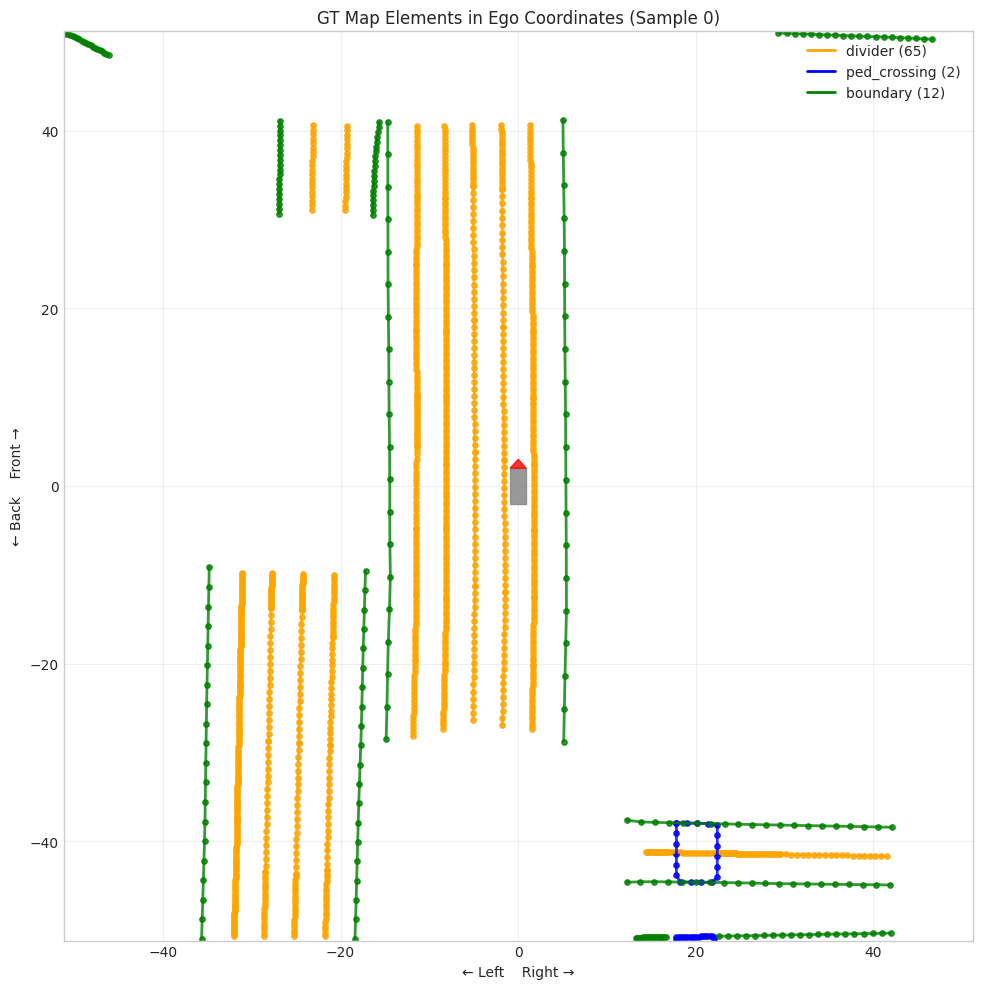


Total elements: 79
  divider: 65
  ped_crossing: 2
  boundary: 12


In [208]:
# Ego 좌표계에서 GT map elements 시각화
import torch

gt_bboxes_3d = data['gt_bboxes_3d'].data
gt_labels_3d = data['gt_labels_3d'].data

# pc_range 가져오기
pc_range = cfg.point_cloud_range  # [x_min, y_min, z_min, x_max, y_max, z_max]
print(f"PC Range: {pc_range}")

# 클래스 이름 및 색상
class_names = ['divider', 'ped_crossing', 'boundary']
COLORS_PLT = ['orange', 'blue', 'green']

fig, ax = plt.subplots(figsize=(10, 10))

# 시각화 범위 설정: X(전방)가 위, Y(왼쪽)가 왼쪽
# plot 좌표: plot_x = -ego_y, plot_y = ego_x
ax.set_xlim(-pc_range[4], -pc_range[1])  # -Y range
ax.set_ylim(pc_range[0], pc_range[3])    # X range
ax.set_aspect('equal')

num_elements = {'divider': 0, 'ped_crossing': 0, 'boundary': 0}

# fixed_num_sampled_points 사용
if hasattr(gt_bboxes_3d, 'fixed_num_sampled_points'):
    gt_lines = gt_bboxes_3d.fixed_num_sampled_points
    
    for gt_pts, gt_label in zip(gt_lines, gt_labels_3d):
        if isinstance(gt_pts, torch.Tensor):
            pts = gt_pts.numpy()
        else:
            pts = gt_pts
        
        label_idx = int(gt_label)
        if label_idx < 0 or label_idx >= len(class_names):
            continue
        
        ego_x = pts[:, 0]  # forward
        ego_y = pts[:, 1]  # left
        
        # Skip padding values
        valid_mask = (ego_x > -9000) & (ego_y > -9000)
        if not valid_mask.any():
            continue
        
        ego_x = ego_x[valid_mask]
        ego_y = ego_y[valid_mask]
        
        # Transform: plot_x = -ego_y, plot_y = ego_x
        plot_x = -ego_y
        plot_y = ego_x
        
        ax.plot(plot_x, plot_y, color=COLORS_PLT[label_idx], linewidth=2, alpha=0.8)
        ax.scatter(plot_x, plot_y, color=COLORS_PLT[label_idx], s=15, alpha=0.8)
        
        num_elements[class_names[label_idx]] += 1

# 차량 표시 (ego 위치)
car_body = plt.Rectangle((-0.9, -2.0), 1.8, 4.0, color='gray', alpha=0.8, zorder=10)
car_front = plt.Polygon([[-0.9, 2.0], [0.9, 2.0], [0, 3.0]], color='red', alpha=0.8, zorder=11)
ax.add_patch(car_body)
ax.add_patch(car_front)

# Legend
legend_elements = [
    plt.Line2D([0], [0], color='orange', lw=2, label=f'divider ({num_elements["divider"]})'),
    plt.Line2D([0], [0], color='blue', lw=2, label=f'ped_crossing ({num_elements["ped_crossing"]})'),
    plt.Line2D([0], [0], color='green', lw=2, label=f'boundary ({num_elements["boundary"]})')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

ax.set_xlabel('← Left    Right →', fontsize=10)
ax.set_ylabel('← Back    Front →', fontsize=10)
ax.set_title(f'GT Map Elements in Ego Coordinates (Sample {sample_idx})', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTotal elements: {sum(num_elements.values())}")
for name, count in num_elements.items():
    print(f"  {name}: {count}")

## 10. NavSim 맵의 모든 레이어 시각화

In [209]:
# NavSim GPKG 맵의 모든 레이어 확인
print("=== all_layers에 로드된 모든 레이어 ===")
for name, gdf in all_layers.items():
    if gdf is not None and len(gdf) > 0:
        geom_types = gdf.geom_type.unique().tolist() if 'geometry' in gdf.columns else ['No geometry']
        print(f"{name}: {len(gdf)} records, geometry: {geom_types}")

=== all_layers에 로드된 모든 레이어 ===
baseline_paths: 4583 records, geometry: ['LineString']
carpark_areas: 71 records, geometry: ['Polygon']
generic_drivable_areas: 128 records, geometry: ['Polygon']
dubins_nodes: 5444 records, geometry: ['Point']
lane_connectors: 2544 records, geometry: ['LineString']
intersections: 522 records, geometry: ['Polygon']
boundaries: 12092 records, geometry: ['LineString']
crosswalks: 233 records, geometry: ['Polygon']
lanes_polygons: 2039 records, geometry: ['Polygon']
lane_group_connectors: 1076 records, geometry: ['Polygon']
lane_groups_polygons: 807 records, geometry: ['Polygon']
road_segments: 662 records, geometry: ['Polygon']
stop_polygons: 567 records, geometry: ['Polygon']
traffic_lights: 597 records, geometry: ['Point']
walkways: 276 records, geometry: ['Polygon']
meta: 3 records, geometry: ['No geometry']
gen_lane_connectors_scaled_width_polygons: 2544 records, geometry: ['Polygon']
